In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings('ignore')

In [408]:
import scipy.io
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
from scipy.optimize import fmin_cg

## Machine Learning: Programming Exercise 8
## Anomaly Detection and Recommender Systems
## 1. Anomaly Detection
In this exercise, you will implement an anomaly detection algorithm to detect anomalous behavior in server computers. The features measure the throughput (mb/s) and latency (ms) of response of each server. While your servers were operating, you collected $m=307$ examples of how they were behaving, and thus have an unlabeled dataset $\{x^{(1)},\ldots,x^{(m)}\}$. You suspect that the vast majority of these examples are 'normal' (non-anomalous) examples of the servers operating normally, but there might also be some examples of servers acting anomalously within this dataset.  
You will use a Gaussian model to detect anomalous examples in your dataset. You will first start on a 2D dataset that will allow you to visualize what the algorithm is doing. On that dataset you will fit a Gaussian distribution and then find values that have very low probability and hence can be considered anomalies. After that, you will apply the anomaly detection algorithm to a larger dataset with many dimensions. The code below will visualize the dataset as shown in Figure 1.

In [178]:
mat = scipy.io.loadmat('ex8data1.mat')
X = mat['X']
Xval = mat['Xval']
yval = mat['yval']

<Figure size 432x360 with 0 Axes>

Text(0.5, 0, 'Latency (ms)')

Text(0, 0.5, 'Throughput (mb/s)')

Text(0.5, 1.0, 'Figure 1: The First Dataset.')

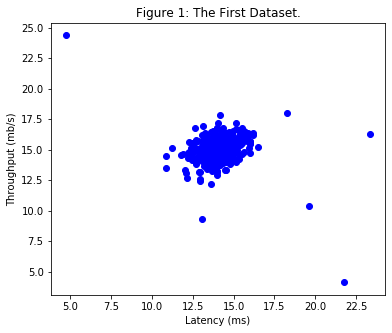

In [179]:
plt.figure(figsize=(6,5))
plt.scatter(x = X[:,0], y =X[:,1], c='blue')
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.title('Figure 1: The First Dataset.')

### 1.1 Gaussian distribution
To perform anomaly detection, you will first need to fit a model to the data's distribution. Given a training set $\{x^{(1)},\dots,x^{(m)}\}$ (where $x^{(i)}\in\mathbb{R}^n$), you want to estimate the Gaussian distribution for each of the features $x_i$. For each feature $i = 1\ldots n$ you need to find parameters $\mu_i$ and $\sigma^2_i$ that fit the data in the $i$-th dimension $\{x_i^{(1)},\ldots,x^{(m)}_i\}$(the $i$-th dimension of each example).  
    The Gaussian distribution is given by  
<center>$p(x;\mu,\sigma^2)=\frac{1}{\sqrt{2\pi\sigma^2}}e^{-\frac{(x-\mu)^2}{2\sigma^2}}$</center>
where $\mu$ is the mean and $\sigma^2$ controls the variance.  

### 1.2 Estimating parameters for a Gaussian
You can estimate the parameters, $(\mu_i,\sigma_i^2)$, of the $i$-th feature by using the following equations. To estimate the mean, you will use:
<center>$\mu_i = \frac{1}{m}\sum_{j=1}^m{x^{(j)}}$</center>
and for the variance you will use: 
<center>$\sigma^2_i = \frac{1}{m}\sum_{j=1}^m{(x^{(j)}-\mu_i)^2}$</center>

In [10]:
def estimateGaussian(X):
    (m, n) = X.shape
    mu = X.mean(axis=0)
    sigma2 = X.var(axis=0)
    return mu, sigma2

In [180]:
mu, sigma2 = estimateGaussian(X)

In [181]:
mu, sigma2

(array([14.11222578, 14.99771051]), array([1.83263141, 1.70974533]))

In [182]:
def multivariateGaussian(X, mu, sigma2):
    k = len(mu)
    if len(sigma2.shape) == 1:
        sigma2 = np.diag(sigma2)
    elif (sigma2.shape[0] == 1) or (sigma2.shape[1] == 1):
        sigma2 = np.diag(sigma2)
    X = X - mu
    p = ((2 * math.pi)**(-k/2))*(np.linalg.det(sigma2)**(-0.5))*np.exp(
        -0.5*np.sum(np.dot(X,np.linalg.pinv(sigma2))*X, axis=1))
    return p

In [218]:
p = multivariateGaussian(X, mu, sigma2)

### 1.3 Selecting the threshold, $\epsilon$
Now that you have estimated the Gaussian parameters, you can investigate which examples have a very high probability given this distribution and which examples have a very low probability. The low probability examples are more likely to be the anomalies in our dataset. One way to determine which examples are anomalies is to select a threshold based on a cross validation set. In this part of the exercise, you will implement an algorithm to select the threshold  using the $F_1$ score on a cross validation set.  

 You should now complete the function selectThreshold. For this, we will use a cross validation set $\{(x^{(1)}_{cv},y^{(1)}_{cv}),\ldots, (x^{(m)}_{cv},y^{(m)}_{cv})\}$, where the label $y=1$ corresponds to an anomalous example, and $y=0$ corresponds to a normal example. For each cross validation example, we will compute $p(x^{(i)}_{cv})$. The vector of all of these probabilities $p(x^{(1)}_{cv}),\ldots,p(x^{(m)}_{cv})$ is passed to selectThreshold.m in the vector pval. The corresponding labels $y^{(1)}_{cv},\ldots,y^{m)}_{cv}$ is passed to the same function in the vector yval.  
 
 The function selectThreshold.m should return two values; the first is the selected threshold $\epsilon$. If an example $x$ has a low probability $p(x) < \epsilon$, then it is considered to be an anomaly. The function should also return the $F_1$ score, which tells you how well you're doing on finding the ground truth anomalies given a certain threshold. For many different values of $\epsilon$, you will compute the resulting $F_1$ score by computing how many examples the current threshold classifies correctly and incorrectly.  
 
 The $F_1$ score is computed using precision (prec) and recall (rec):

<center>$F_1 = \frac{2 ( prec)(rec)}{prec + rec}$</center>

You compute precision and recall by:

<center>$prec = \frac{tp}{tp + fp}$</center>
<center>$rec = \frac{tp}{tp + fn}$</center>

In [195]:
def selectThreshold(yval, pval):
    best_epsilon = 0
    max_f1 = 0
    step_size = (max(pval)-min(pval))/1000
    for epsilon in np.arange(min(pval), max(pval), step_size):
        predictions = (pval < epsilon)
        fp = np.sum((predictions == 1) & (yval.flatten() == 0))
        fn = np.sum((predictions == 0) & (yval.flatten() == 1))
        tp = np.sum((predictions == 1) & (yval.flatten() == 1))
        prec = tp / (tp + fp)
        rec = tp / (tp + fn)
        F1 = 2 * prec * rec / (prec + rec)
        if F1 > max_f1:
            max_f1 = F1
            best_epsilon = epsilon
    return best_epsilon, max_f1

In [196]:
pval = multivariateGaussian(Xval, mu, sigma2)
epsilon, F1 = selectThreshold(yval, pval)

In [197]:
print('Best epsilon found using cross-validation: ', epsilon)
print('Best F1 on Cross Validation Set: ', F1)

Best epsilon found using cross-validation:  8.990852779269495e-05
Best F1 on Cross Validation Set:  0.8750000000000001


<Figure size 432x360 with 0 Axes>

Text(0.5, 0, 'Latency (ms)')

Text(0, 0.5, 'Throughput (mb/s)')

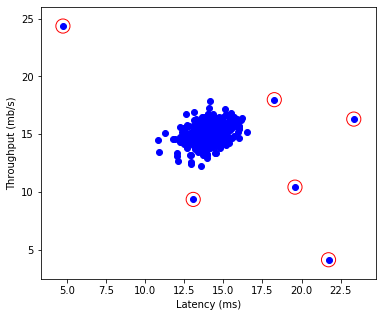

In [219]:
plt.figure(figsize=(6,5))
plt.scatter(x = X[:,0], y =X[:,1], c='blue')
plt.scatter(x = np.where(p.reshape(len(pval), 1)<epsilon, X, None)[:,0], 
            y =np.where(p.reshape(len(pval), 1)<epsilon, X, None)[:,1], 
            marker='o', c='none', edgecolors='red',s=200)
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')

### 1.4 High dimensional dataset
The code in this section will run the anomaly detection algorithm you implemented on a more realistic and much harder dataset. In this dataset, each example is described by 11 features, capturing many more properties of your compute servers. The code below will use your code to estimate the Gaussian parameters ($\mu_i$ and $\sigma^2_i$), evaluate the probabilities for both the training data X from which you estimated the Gaussian parameters, and do so for the the cross-validation set Xval. Finally, it will use selectThreshold to find the best threshold $\epsilon$. You should see a value epsilon of about 1.38e-18, and 117 anomalies found.

In [220]:
mat = scipy.io.loadmat('ex8data2.mat')
X = mat['X']
Xval = mat['Xval']
yval = mat['yval']

In [222]:
mu, sigma2 = estimateGaussian(X)
p = multivariateGaussian(X, mu, sigma2)
pval = multivariateGaussian(Xval, mu, sigma2)
epsilon, F1 = selectThreshold(yval, pval)
print('Best epsilon found using cross-validation: ', epsilon)
print('Best F1 on Cross Validation Set: ', F1)
print('# Outliers found: ', sum(p < epsilon))

Best epsilon found using cross-validation:  1.377228890761358e-18
Best F1 on Cross Validation Set:  0.6153846153846154
# Outliers found:  117


## 2. Recommender Systems
In this part of the exercise, you will implement the collaborative filtering learning algorithm and apply it to a dataset of movie ratings*. This dataset consists of ratings on a scale of 1 to 5. The dataset has  users, and  movies.  
### 2.1 Movie ratings dataset
The matrix Y (a num_movies  num_users matrix) stores the ratings  $y^{(i,j)}$(from 1 to 5). The matrix R is an binary-valued indicator matrix, where $R(i,j) = 1$ if user $j$ gave a rating to movie $i$, and $R(i,j) = 0$ otherwise. The objective of collaborative filtering is to predict movie ratings for the movies that users have not yet rated, that is, the entries with $R(i,j) = 0$. This will allow us to recommend the movies with the highest predicted ratings to the user.  
 To help you understand the matrix $Y$, the code below will compute the average movie rating for the first movie (Toy Story) and output the average rating to the screen. Throughout this part of the exercise, you will also be working with the matrices, $X$ and $Theta$:

In [223]:
mat = scipy.io.loadmat('ex8_movies.mat')
Y = mat['Y']
R = mat['R']

In [224]:
Y.shape
R.shape

(1682, 943)

(1682, 943)

- Y is a 1682 x 943 matrix, containing ratings (1 - 5) of 1682 movies on 943 users  
- R is a 1682 x 943 matrix, where R(i,j) = 1 if and only if user j gave a rating to movie i

In [249]:
print('Average rating for movie 1 (Toy Story): %f/5'%np.mean(Y[0, np.where(R[0, :]==1)]))

Average rating for movie 1 (Toy Story): 3.878319/5


<Figure size 864x432 with 0 Axes>

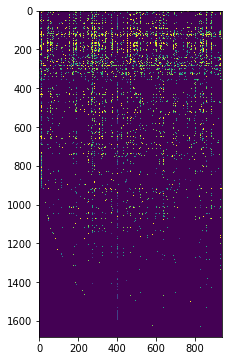

In [267]:
plt.figure(figsize=(12,6))
plt.imshow(Y, extent=[0, Y.shape[1], Y.shape[0], 0])

### 2.2 Collaborative filtering learning algorithm

Now, you will start implementing the collaborative filtering learning algorithm. You will start by implementing the cost function (without regularization). The collaborative filtering algorithm in the setting of movie recommendations considers a set of $n$-dimensional parameter vectors $x^{(1)},\ldots,x^{(n_m)}$ and $\theta^{(1)},\ldots, \theta^{(n_u)}$, where the model predicts the rating for movie $i$ by user $j$ as $y^{(i,j)} = (\theta^{(j)})^T x^{(i)}$. Given a dataset that consists of a set of ratings produced by some users on some movies, you wish to learn the parameter vectors $x^{(1)},\ldots,x^{(n_m)},\;\theta^{(1)},\ldots,\theta^{(n_u)}$ that produce the best fit (minimizes the squared error).
    You will complete the code in cofiCostFunc to compute the cost function and gradient for collaborative filtering.
    
#### 2.2.1 Collaborative filtering cost function
The collaborative filtering cost function (without regularization) is given by  
<center>$J\left(x^{(i)},\ldots,x^{(n_m)},\;\theta^{(1)},\ldots,\theta^{(n_u)}\right)
=\frac{1}{2}\sum_{(i,j):r(i,j)=1}\left((\theta^{(j)})^Tx^{(i)}-y^{(i,j)}\right)^2$</center>

You should now modify cofiCostFunc.m to return this cost in the variable J. Note that you should be accumulating the cost for user $i$ and movie $j$ only if $R(i,j) = 1$. After you have completed the function, the code below will run your cost function. You should expect to see an output of 22.22.

In [336]:
def cofiCostFunc1(params, **kwargs):
    Y = kwargs["Y"]
    R = kwargs["R"]
    num_users = kwargs["num_users"]
    num_movies = kwargs["num_movies"]
    num_features = kwargs["num_features"]
    reg = kwargs["reg"]
    
    X = params[:num_movies*num_features].reshape(num_movies, num_features)
    Theta = params[num_movies*num_features:].reshape(num_users, num_features)
    J = 1/2 * sum(sum((R* ((X.dot(Theta.T) - Y))**2)))
    return J

In [337]:
mat = scipy.io.loadmat('ex8_movieParams.mat')
X = mat['X']
Theta = mat['Theta']

In [340]:
num_users = 4
num_movies = 5
num_features = 3
X = X[:num_movies, :num_features]
Theta = Theta[:num_users, :num_features]
Y = Y[:num_movies, :num_users]
R = R[:num_movies, :num_users]
params = np.concatenate([X.flatten(), Theta.flatten()])

kwargs = {"Y":Y, "R":R, "num_users":num_users, "num_movies":num_movies, "num_features":num_features, "reg":0}
J = cofiCostFunc1(params, **kwargs)
print('Cost at loaded parameters: ',J)

Cost at loaded parameters:  22.22460372568567


#### 2.2.2 Collaborative filtering gradient
Now, you should implement the gradient (without regularization). Specically, you should complete the code in cofiCostFunc.m to return the variables X_grad and Theta_grad. Note that X_grad should be a matrix of the same size as X and similarly, Theta_grad is a matrix of the same size as Theta. The gradients of the cost function is given by:  
<center>$\frac{\partial J}{\partial x_k^{(i)}} 
= \sum_{j:r(i,j)=1}\left((\theta^{(j)})^T x^{(i)} -y^{(i,j)}\right)\theta_k^{(j)}$</center>
<center>$\frac{\partial J}{\partial \theta_k^{(j)}} = \sum_{i:r(i,j)=1}\left((\theta^{(j)})^T x^{(i)} -y^{(i,j)}\right) x_k^{(i)}$</center>

In [342]:
def cofiCostFunc2(params, **kwargs):
    Y = kwargs["Y"]
    R = kwargs["R"]
    num_users = kwargs["num_users"]
    num_movies = kwargs["num_movies"]
    num_features = kwargs["num_features"]
    reg = kwargs["reg"]
    
    X = params[:num_movies*num_features].reshape(num_movies, num_features)
    Theta = params[num_movies*num_features:].reshape(num_users, num_features)
    J = 1/2 * sum(sum((R* ((X.dot(Theta.T) - Y))**2)))
    X_grad = (R * (X.dot(Theta.T) - Y)).dot(Theta)
    Theta_grad = (R * (X.dot(Theta.T) - Y)).T.dot(X)
    grad = np.concatenate([X_grad.flatten(), Theta_grad.flatten()])
    return J, grad

In [343]:
kwargs = {"Y":Y, "R":R, "num_users":num_users, "num_movies":num_movies, "num_features":num_features, "reg":0}
J, grad = cofiCostFunc2(params, **kwargs)

In [344]:
grad[:5]

array([-2.52899165,  7.57570308, -1.89979026, -0.56819597,  3.35265031])

In [345]:
def computeNumericalGradient(J, theta):
    numgrad = np.zeros(theta.shape) 
    perturb = np.zeros(theta.shape) 
    e = 1e-4 
    # Check the first 5 grads
    for p in range(5):
        # Set perturbation vector
        perturb[p] = e
        loss1 = J(theta - perturb, **kwargs) 
        loss2 = J(theta + perturb, **kwargs) 
        # Compute Numerical Gradient
        numgrad[p] = (loss2 - loss1) / (2*e) 
        perturb[p] = 0
    return numgrad

kwargs = {"Y":Y, "R":R, "num_users":num_users, "num_movies":num_movies, "num_features":num_features, "reg":0}
numeric_grad = computeNumericalGradient(cofiCostFunc1, params)
numeric_grad[:5]

array([-2.52899165,  7.57570308, -1.89979026, -0.56819597,  3.35265031])

#### 2.2.4 Regularized gradient
<center>$\frac{\partial J}{\partial x_k^{(i)}} 
= \sum_{j:r(i,j)=1}\left((\theta^{(j)})^T x^{(i)} -y^{(i,j)}\right)\theta_k^{(j)}+\lambda x_k^{(i)}$</center>
<center>$\frac{\partial J}{\partial \theta_k^{(j)}} = \sum_{i:r(i,j)=1}\left((\theta^{(j)})^T x^{(i)} -y^{(i,j)}\right) x_k^{(i)}+\lambda\theta_k^{(j)}$</center>

In [410]:
def cofiCostFunc1(params, **kwargs):
    Y = kwargs["Y"]
    R = kwargs["R"]
    num_users = kwargs["num_users"]
    num_movies = kwargs["num_movies"]
    num_features = kwargs["num_features"]
    reg = kwargs["reg"]
    
    X = params[:num_movies*num_features].reshape(num_movies, num_features)
    Theta = params[num_movies*num_features:].reshape(num_users, num_features)
    J = 1/2 * sum(sum((R* ((X.dot(Theta.T) - Y))**2)))
    J += reg/2 * (sum(sum(Theta**2)) + sum(sum(X**2)))
    return J

def cofiCostFunc3(params, **kwargs):
    Y = kwargs["Y"]
    R = kwargs["R"]
    num_users = kwargs["num_users"]
    num_movies = kwargs["num_movies"]
    num_features = kwargs["num_features"]
    reg = kwargs["reg"]
    
    X = params[:num_movies*num_features].reshape(num_movies, num_features)
    Theta = params[num_movies*num_features:].reshape(num_users, num_features)
    J = 1/2 * sum(sum((R* ((X.dot(Theta.T) - Y))**2)))
    X_grad = (R * (X.dot(Theta.T) - Y)).dot(Theta)
    Theta_grad = (R * (X.dot(Theta.T) - Y)).T.dot(X)
    
    
    J += reg/2 * (sum(sum(Theta**2)) + sum(sum(X**2)))
    X_grad += reg * X
    Theta_grad += reg * Theta
    grad = np.concatenate([X_grad.flatten(), Theta_grad.flatten()])
    return J, grad

In [347]:
kwargs = {"Y":Y, "R":R, "num_users":num_users, "num_movies":num_movies, "num_features":num_features, "reg":1.5}
J, grad = cofiCostFunc3(params, **kwargs)
grad[:5]

array([-0.95596339,  6.97535514, -0.10861109,  0.60308088,  2.77421145])

In [348]:
numeric_grad = computeNumericalGradient(cofiCostFunc1, params)
numeric_grad[:5]

array([-0.95596339,  6.97535514, -0.10861109,  0.60308088,  2.77421145])

### 2.3 Learning movie recommendations
After you have finished implementing the collaborative ltering cost function and gradient, you can now start training your algorithm to make movie recommendations for yourself. In the code below, you can enter your own movie preferences, so that later when the algorithm runs, you can get your own movie recommendations! We have filled out some values according to our own preferences, but you should change this according to your own tastes. The list of all movies and their number in the dataset can be found listed in the file movie idx.txt.

In [374]:
movieList = list(pd.read_csv('movie_ids.txt', header=None, sep='\t', encoding = "latin").iloc[:,0].values)

In [380]:
movieList

['1 Toy Story (1995)',
 '2 GoldenEye (1995)',
 '3 Four Rooms (1995)',
 '4 Get Shorty (1995)',
 '5 Copycat (1995)',
 '6 Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)',
 '7 Twelve Monkeys (1995)',
 '8 Babe (1995)',
 '9 Dead Man Walking (1995)',
 '10 Richard III (1995)',
 '11 Seven (Se7en) (1995)',
 '12 Usual Suspects, The (1995)',
 '13 Mighty Aphrodite (1995)',
 '14 Postino, Il (1994)',
 "15 Mr. Holland's Opus (1995)",
 '16 French Twist (Gazon maudit) (1995)',
 '17 From Dusk Till Dawn (1996)',
 '18 White Balloon, The (1995)',
 "19 Antonia's Line (1995)",
 '20 Angels and Insects (1995)',
 '21 Muppet Treasure Island (1996)',
 '22 Braveheart (1995)',
 '23 Taxi Driver (1976)',
 '24 Rumble in the Bronx (1995)',
 '25 Birdcage, The (1996)',
 '26 Brothers McMullen, The (1995)',
 '27 Bad Boys (1995)',
 '28 Apollo 13 (1995)',
 '29 Batman Forever (1995)',
 '30 Belle de jour (1967)',
 '31 Crimson Tide (1995)',
 '32 Crumb (1994)',
 '33 Desperado (1995)',
 '34 Doom Generation, The (1995)',
 '35

In [390]:
my_ratings = np.zeros((1682, 1))
# Check the file movie_idx.txt for id of each movie in our dataset
# For example, Toy Story [1995] has ID 1, so to rate it "4", you can set
my_ratings[0] = 4;
# Or suppose did not enjoy Silence of the Lambs [1991], you can set
my_ratings[97] = 2; 

# We have selected a few movies we liked / did not like and the ratings we gave are as follows:
my_ratings[6] = 3;
my_ratings[11]= 5;
my_ratings[53] = 4;
my_ratings[63]= 5;
my_ratings[65]= 3;
my_ratings[68] = 5;
my_ratings[182] = 4;
my_ratings[225] = 5;
my_ratings[354]= 5;

#### 2.3.1 Recommendations

After the additional ratings have been added to the dataset, the code below will proceed to train the collaborative filtering model. This will learn the parameters X and Theta. 

In [421]:
mat = scipy.io.loadmat('ex8_movies.mat')
Y = mat['Y']
R = mat['R']
Y = np.concatenate((my_ratings, Y), axis=1)
R = np.concatenate((np.where(my_ratings != 0, 1, 0), R), axis=1)

In [422]:
def normalizeRatings(Y, R):
    m, n = Y.shape
    Ymean = np.zeros((m, 1))
    Ynorm = np.zeros(Y.shape)
    for i in range(m):
        idx = np.where(R[i, :]==1)
        Ymean[i] = np.mean(Y[i, idx])
        Ynorm[i, idx] = Y[i, idx] - Ymean[i]
    return Ymean, Ynorm

In [423]:
Ymean, Ynorm = normalizeRatings(Y, R)

num_users = Y.shape[1]
num_movies = Y.shape[0]
num_features = 10

# Set Initial Parameters (Theta, X)
X = np.random.rand(num_movies, num_features)
Theta = np.random.rand(num_users, num_features)
initial_parameters = np.concatenate([X.flatten(), Theta.flatten()])
# Set Regularization
reg = 10

kwargs = {"Y":Ynorm, "R":R, "num_users":num_users, "num_movies":num_movies, "num_features":num_features, "reg":reg}
theta = fmin_cg(lambda x: cofiCostFunc3(x, **kwargs)[0], x0=initial_parameters, 
                fprime=lambda x: cofiCostFunc3(x, **kwargs)[1])

Optimization terminated successfully.
         Current function value: 38951.847560
         Iterations: 445
         Function evaluations: 666
         Gradient evaluations: 666


In [424]:
X = np.reshape(theta[:num_movies*num_features], (num_movies, num_features))
Theta = np.reshape(theta[num_movies*num_features:], (num_users, num_features))

To predict the rating of movie $i$ for user $j$, you need to compute $(\theta^{(j)})^T x^{(i)}$ The code below computes the ratings for all the movies and users and displays the movies that it recommends (Figure 4), according to ratings that were entered earlier in the script. Note that you might obtain a different set of the predictions due to different random initializations.

In [453]:
p = X.dot(Theta.T)
my_predictions = p[:,0] + Ymean.flatten()

n = 10
ranked = np.argsort(my_predictions)
largest_indices = ranked[::-1][:n]
for i in range(n):
    j = largest_indices[i]
    if i == 0:
        print('Top recommendations for you: ')
    print('Predicting rating %.1f for movie %s'%(my_predictions[j], movieList[j]))

Top recommendations for you: 
Predicting rating 5.0 for movie 814 Great Day in Harlem, A (1994)
Predicting rating 5.0 for movie 1189 Prefontaine (1997)
Predicting rating 5.0 for movie 1653 Entertaining Angels: The Dorothy Day Story (1996)
Predicting rating 5.0 for movie 1122 They Made Me a Criminal (1939)
Predicting rating 5.0 for movie 1467 Saint of Fort Washington, The (1993)
Predicting rating 5.0 for movie 1201 Marlene Dietrich: Shadow and Light (1996) 
Predicting rating 5.0 for movie 1293 Star Kid (1997)
Predicting rating 5.0 for movie 1599 Someone Else's America (1995)
Predicting rating 5.0 for movie 1536 Aiqing wansui (1994)
Predicting rating 5.0 for movie 1500 Santa with Muscles (1996)
